In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import sqlalchemy as db
from scipy import stats

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

from kmodes.kprototypes import KPrototypes
from sklearn.manifold import TSNE
from sklearn.model_selection import RandomizedSearchCV


In [2]:
engine = db.create_engine('sqlite:///Данные/shop_database.db')
conn = engine.connect()

In [3]:
df_personal_data = pd.read_sql(sql=db.text('SELECT * FROM personal_data'),con=conn)
df_personal_data_coeffs = pd.read_sql(sql=db.text('SELECT * FROM personal_data_coeffs'),con=conn)
df_purchases = pd.read_sql(sql=db.text('SELECT * FROM purchases'),con=conn)
df_lost = pd.read_csv('Данные/personal_data.csv.gz', compression='gzip', header=0)

In [4]:
# Объединение данных о клиентах и утерянные данные
df_personal_full = pd.concat([df_personal_data,df_lost])

In [5]:
# Объединение  данных о клиентах и данных с персональными коэффициентами
df_clients = df_personal_full.merge(df_personal_data_coeffs[['id','personal_coef']], how='inner',on='id')
df_clients = df_clients[df_clients['country'] == 32]
df_clients

,id,gender,age,education,city,country,personal_coef
0,0,0.0,36,среднее,1201,32,0.5072
1,4,0.0,35,среднее,1134,32,0.5072
2,6,1.0,52,среднее,1188,32,0.4304
3,7,0.0,37,среднее,1198,32,0.5072
4,9,0.0,48,среднее,1134,32,0.5072
...,...,...,...,...,...,...,...
104984,135183,NaN,44,среднее,1134,32,0.4304
104985,125993,NaN,46,среднее,1134,32,0.4304
104986,167019,NaN,71,среднее,1134,32,0.5072
104987,116355,NaN,32,среднее,1188,32,0.4304


In [6]:
# Проверка незаполненных значений в столбцах
print(f'Количество дубликатов в df: {df_clients.duplicated().sum()}')
print('Количество полностью заполненных объектов из всей выборки:', len(df_clients.dropna()))
print('Процент полностью заполненных объектов из всей выборки:', round(len(df_clients.dropna()) / len(df_clients) * 100, 2))
missing_values = ((df_clients.isna().sum()/len(df_clients))*100).sort_values(ascending=False)
print('Процент пропущенных значений:\n', missing_values[missing_values > 0])

Количество дубликатов в df: 0
Количество полностью заполненных объектов из всей выборки: 88786
Процент полностью заполненных объектов из всей выборки: 85.01
Процент пропущенных значений:
 gender    14.986068
dtype: float64


#### Биннарная классификация

In [7]:
# Кодирование данных об образовании
le = LabelEncoder()
df_clients['education'] = le.fit_transform(df_clients['education'])
df_clients.head()

,id,gender,age,education,city,country,personal_coef
0,0,0.0,36,1,1201,32,0.5072
1,4,0.0,35,1,1134,32,0.5072
2,6,1.0,52,1,1188,32,0.4304
3,7,0.0,37,1,1198,32,0.5072
4,9,0.0,48,1,1134,32,0.5072


In [8]:
#Разделение сета на тестовую и обучающую группы 
df_train = df_clients[~df_clients['gender'].isna()].dropna()
df_test = df_clients[df_clients['gender'].isna()]
x_train = df_train.drop(columns=['gender','id','personal_coef']) 
y_train = df_train['gender']
x_test = df_test.drop(columns=['gender','id','personal_coef']) 
y_test = df_test['gender']


In [9]:
# Модель логистической регрессии
logreg = LogisticRegression (random_state=42)
logreg.fit(x_train, y_train)
logreg_pred_train = logreg.predict(x_train)

In [10]:
print(accuracy_score(y_train, logreg_pred_train))
print(f1_score(y_train, logreg_pred_train))


0.5723312233910751
0.7196077417830322


In [11]:
# Модель случайного леса
RFC = RandomForestClassifier (random_state=42)
RFC.fit(x_train, y_train)
predicted_train_rf = RFC.predict(x_train)

In [12]:
print(accuracy_score(y_train, predicted_train_rf))
print(f1_score(y_train, predicted_train_rf))

0.6290744036221927
0.7196356361469374


In [13]:
# Модель многослойный персептрон
clf = MLPClassifier()
clf.fit(x_train, y_train)
predicted_train_clf = clf.predict(x_train)

In [14]:
print(accuracy_score(y_train, predicted_train_clf))
print(f1_score(y_train, predicted_train_clf))

0.5739756267880071
0.7276131494617074


In [15]:
# Обучение тестовой выборки 
model = RandomForestClassifier(random_state=42).fit(x_train, y_train)
pred_rf = model.predict(x_train)
df_test['gender'] = model.predict(x_test)

C:\Users\svu20\AppData\Local\Temp\ipykernel_2412\88150107.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['gender'] = model.predict(x_test)


In [16]:
print(accuracy_score(y_train,pred_rf ))
print(f1_score(y_train,pred_rf ))

0.6290744036221927
0.7196356361469374


In [17]:
df_test['gender'].value_counts()

gender
1.0    11734
0.0     3917
Name: count, dtype: int64

In [18]:
# Объединение датафреймов 
df_clients = pd.concat([df_train, df_test])
df_clients

,id,gender,age,education,city,country,personal_coef
0,0,0.0,36,1,1201,32,0.5072
1,4,0.0,35,1,1134,32,0.5072
2,6,1.0,52,1,1188,32,0.4304
3,7,0.0,37,1,1198,32,0.5072
4,9,0.0,48,1,1134,32,0.5072
...,...,...,...,...,...,...,...
104984,135183,1.0,44,1,1134,32,0.4304
104985,125993,1.0,46,1,1134,32,0.4304
104986,167019,1.0,71,1,1134,32,0.5072
104987,116355,1.0,32,1,1188,32,0.4304


In [19]:
df_purchases

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27
...,...,...,...,...,...,...,...
786255,178004,Полуботинки мужские Ascot Vortex,хаки/черный,7999,1.0,0,12
786256,178004,Кроссовки мужские Nike Air Max 90,черный/серый,24299,1.0,0,13
786257,178004,Кроссовки мужские Nike Air Max 90,черный/серый,24299,1.0,0,20
786258,178004,Пакет,коричневый,12,NaN,0,20


In [20]:
# Проверка незаполненных значений в столбцах
print(f'Количество дубликатов в df: {df_purchases.duplicated().sum()}')
print('Количество полностью заполненных объектов из всей выборки:', len(df_purchases.dropna()))
print('Процент полностью заполненных объектов из всей выборки:', round(len(df_purchases.dropna()) / len(df_purchases) * 100, 2))
missing_values = ((df_purchases.isna().sum()/len(df_purchases))*100).sort_values(ascending=False)
print('Процент пропущенных значений:\n', missing_values[missing_values > 0])

Количество дубликатов в df: 0
Количество полностью заполненных объектов из всей выборки: 394887
Процент полностью заполненных объектов из всей выборки: 50.22
Процент пропущенных значений:
 product_sex    40.026454
colour         15.201587
dtype: float64


In [21]:
df_purchases['colour'].value_counts()

colour
черный                          131399
белый                            42520
чёрный                           37022
синий                            35268
темно-синий                      27257
                                 ...  
черный/красный/лаймовый              1
желтый/белый/черный                  1
черный/серый/зеленый/голубой         1
белый/золотой/красный                1
черный/циан                          1
Name: count, Length: 1693, dtype: int64

In [22]:
# Заполнение пропусков в product_sex 
df_purchases['product_sex'] = df_purchases['product_sex'].fillna(2)

# Заполение пропусков в цвете
df_purchases['colour'] = df_purchases['colour'].fillna('не определено')

# Преобразование различных вариантов написания цветов  с "ё" в один
df_purchases['colour'] = df_purchases['colour'].replace('черный' ,'чёрный').replace('зеленый','зелёный').replace('желтый', 'жёлтый')

# Преобразование значений со множеством цветов в мультицвет
df_purchases['colour'] = df_purchases['colour'].apply(lambda x: 'мультицвет' if x.__contains__('/')  else x )

# Преобразование заглавных букв
df_purchases['colour'] = df_purchases['colour'].apply(lambda x: x.lower())

# Извлечение групп товаров в product
df_purchases['product']  = df_purchases['product'].apply(lambda x: ' '.join(re.findall('[А-Яа-я]{3,20}', x)).lower())


In [23]:
df_full = df_purchases.merge(df_clients, how='left',on='id')
df_full.head()

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef
0,0,велосипед горный женский,мультицвет,13599,0.0,1,7,0.0,36.0,1.0,1201.0,32.0,0.5072
1,0,стол,зелёный,1499,2.0,0,37,0.0,36.0,1.0,1201.0,32.0,0.5072
2,0,набор стол стула,бежевый,4799,2.0,0,37,0.0,36.0,1.0,1201.0,32.0,0.5072
3,3,бутсы мужские,белый,1599,1.0,0,13,1.0,31.0,1.0,1134.0,32.0,0.4304
4,3,мяч футбольный,мультицвет,7199,2.0,0,27,1.0,31.0,1.0,1134.0,32.0,0.4304


### A/B тест

Контрольные метрики для A/B тестирования: 
1. Средняя выручка на одного клиента 

2. Количество покупок на каждого клиента

3. Сумма среднего чека

1 гипотеза:

Основная гипотеза: нет статистически значимой разницы между средней выручкой на одного пользователя в тестовой и контрольной группах.

Альтернативная гипотеза: есть статистически значимая разница между средней выручкой на одного пользователя в тестовой и контрольной группах.


2 гипотеза:

Основная гипотеза: нет статистически значимой разницы между средним количеством купленных товаров в тестовой и контрольной группах.

Альтернативная гипотеза: есть статистически значимая разница между средним количеством купленных товаров в тестовой и контрольной группах.

3 гипотеза:

Основная гипотеза: нет статистически значимой разницы  между суммами в среднем чеке в тестовой и контрольной группах.

Альтернативная гипотеза: есть статистически значимая разница между суммами в среднем чеке в тестовой и контрольной группах.

In [24]:
# Извлекаем id покупателей из тестовой и контрольной группы
with open('Данные/ids_first_company_positive.txt') as f:
    positive = f.read()
match = re.findall(r'\d+', positive)
positive_id = []
for elem in match:
    positive_id.append(int(elem))

In [25]:
with open('Данные/ids_first_company_negative.txt') as f:
    neagtive = f.read()
match = re.findall(r'\d+', neagtive)
negative_id = []
for elem in match:
    negative_id.append(int(elem))   

In [26]:
print(len(positive_id))
print(len(negative_id))

5023
5021


In [27]:
# Извлекаем данные в период проведения компании с 5 по 16:
df = df_full[(df_full['dt'] > 4) & (df_full['dt'] < 17)]


In [28]:
# Получаем значение выручки на одного клиента
abtest_group = df.groupby('id', as_index=False).agg({'cost':'sum'})
# Разбиваем клиентов на тестовую и контрольную группы
positive_group = abtest_group.loc[abtest_group['id'].isin(positive_id), :]
negative_group = abtest_group.loc[abtest_group['id'].isin(negative_id), :]

In [29]:
# Проверка на распределение Кретерий Шапиро-Уилка - pvalue меньше 0.05 , гипотезу о нормальности распределения отклоняется.
print(stats.shapiro(positive_group['cost']))
print(stats.shapiro(negative_group['cost']))

ShapiroResult(statistic=0.5348403804592736, pvalue=1.3957058967704918e-77)
ShapiroResult(statistic=0.47323116209981464, pvalue=2.9841687512879674e-81)


In [30]:
# Выборки независимы , распределение не нормальное , для проверки равенства двух средних применяем кретерий Манна-Уитни
mann = stats.mannwhitneyu(positive_group['cost'], negative_group['cost'])
if mann[1] < 0.05:
    print('Разница статистички значимая')
    print(mann)
else:
    print('Разница статистически не значительная')
    print(mann)

Разница статистички значимая
MannwhitneyuResult(statistic=13824378.5, pvalue=1.6638698624514147e-40)


C:\Users\svu20\AppData\Local\Temp\ipykernel_2412\4134128378.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_group['cost'].mean(),negative_group['cost'].mean()], palette=['#4472C4','Red'])


[Text(0.5, 0, 'Группа'), Text(0, 0.5, 'Выручка')]

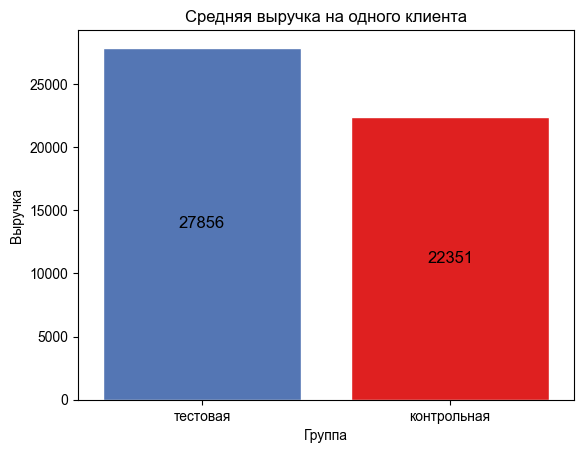

In [31]:
fig,ax= plt.subplots()
sns.set_theme(style="whitegrid")
sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_group['cost'].mean(),negative_group['cost'].mean()], palette=['#4472C4','Red'])
ax.bar_label(ax.containers[0], fontsize=12, label_type='center', color='black', fmt='%.0f')
ax.bar_label(ax.containers[1], fontsize=12, label_type='center', color='black', fmt='%.0f')
ax.set_title('Средняя выручка на одного клиента')
ax.set(xlabel='Группа', ylabel='Выручка')


In [32]:
# Группируем покупупки клиентов по id
abtest_group_count = df.groupby(['id'], as_index=False).agg({'cost':'count'})
# Разбиваем клиентов на тестовую и контрольную группы
positive_group_сount = abtest_group_count.loc[abtest_group_count['id'].isin(positive_id), :]
negative_сount = abtest_group_count.loc[abtest_group_count['id'].isin(negative_id), :]


In [33]:
# Проверка на распределение Кретерий Шапиро-Уилка  - pvalue меньше 0.05 , гипотезу о нормальности распределения отклоняется.
print(stats.shapiro(positive_group['cost']))
print(stats.shapiro(negative_group['cost']))

ShapiroResult(statistic=0.5348403804592736, pvalue=1.3957058967704918e-77)
ShapiroResult(statistic=0.47323116209981464, pvalue=2.9841687512879674e-81)


In [34]:
# Выборки независимы , распределение не нормальное , для проверки равенства двух средних применяем кретерий Манна-Уитни
mann = stats.mannwhitneyu(positive_group_сount['cost'], negative_сount['cost'])
if mann[1] < 0.05:
    print('Разница статистички значимая')
    print(mann)
else:
    print('Разница статистически не значительная')
    print(mann)

Разница статистички значимая
MannwhitneyuResult(statistic=14699602.5, pvalue=2.0498075391196523e-87)


C:\Users\svu20\AppData\Local\Temp\ipykernel_2412\2364625331.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_group_сount['cost'].mean(),negative_сount['cost'].mean()], palette=['#4472C4','Red'] )


[Text(0.5, 0, 'Группа'), Text(0, 0.5, 'Количество товаров')]

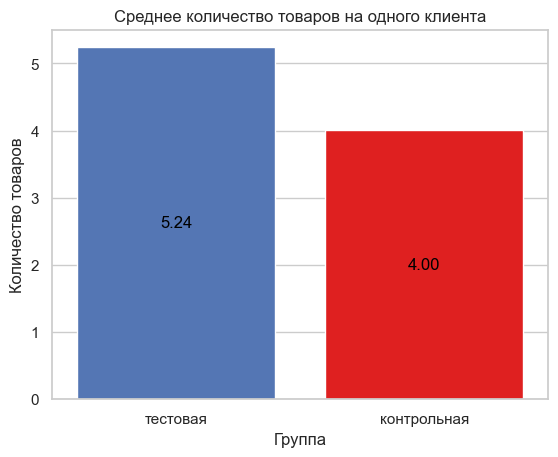

In [35]:
fig,ax= plt.subplots()
sns.set_theme(style="whitegrid")
sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_group_сount['cost'].mean(),negative_сount['cost'].mean()], palette=['#4472C4','Red'] )
ax.bar_label(ax.containers[0], fontsize=12, label_type='center', color='black', fmt='%.2f')
ax.bar_label(ax.containers[1], fontsize=12, label_type='center', color='black', fmt='%.2f')
ax.set_title('Среднее количество товаров на одного клиента')
ax.set(xlabel='Группа', ylabel='Количество товаров')


In [36]:
# получаем условный средний чек по клиентам.
abtest_group_cheek = df.groupby(['dt','id'], as_index=False).agg({'cost':'sum'})
# Разбиваем клиентов на тестовую и контрольную группы
positive_cheek = abtest_group_cheek.loc[abtest_group_cheek['id'].isin(positive_id), :]
negative_cheek = abtest_group_cheek.loc[abtest_group_cheek['id'].isin(negative_id), :]

In [37]:
# Проверка на распределение Кретерий Шапиро-Уилка  - pvalue меньше 0.05 , гипотезу о нормальности распределения отклоняется.
print(stats.shapiro(positive_cheek ['cost']))
print(stats.shapiro(negative_cheek['cost']))

ShapiroResult(statistic=0.564367441645995, pvalue=3.021583851481623e-100)
ShapiroResult(statistic=0.5191872157922892, pvalue=2.0209232452019973e-99)


C:\Users\svu20\AppData\Local\Temp\ipykernel_2412\3604782955.py:2: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12590.
  print(stats.shapiro(positive_cheek ['cost']))
C:\Users\svu20\AppData\Local\Temp\ipykernel_2412\3604782955.py:3: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11114.
  print(stats.shapiro(negative_cheek['cost']))


C:\Users\svu20\AppData\Local\Temp\ipykernel_2412\2124446756.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_cheek['cost'].mean(),negative_cheek['cost'].mean()], palette=['#4472C4','Red'] )


[Text(0.5, 0, 'Группа'), Text(0, 0.5, 'Сумма')]

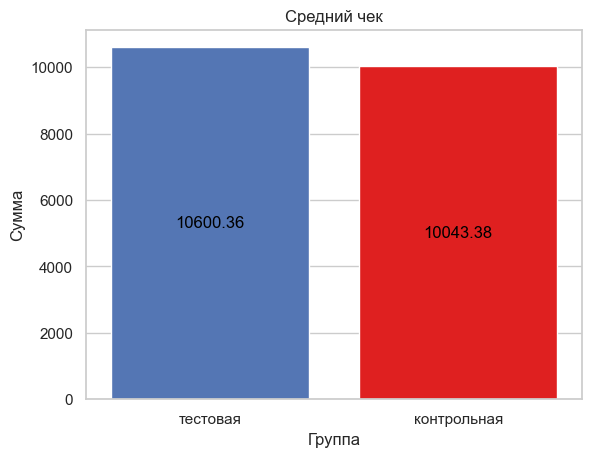

In [38]:
fig,ax= plt.subplots()
sns.set_theme(style="whitegrid")
sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_cheek['cost'].mean(),negative_cheek['cost'].mean()], palette=['#4472C4','Red'] )
ax.bar_label(ax.containers[0], fontsize=12, label_type='center', color='black', fmt='%.2f')
ax.bar_label(ax.containers[1], fontsize=12, label_type='center', color='black', fmt='%.2f')
ax.set_title('Средний чек')
ax.set(xlabel='Группа', ylabel='Сумма')


#### Выводы A/B тестов по результатам маркетинговой компании №1: 

По результатам A/B тестов выявлена значимая разница во всех выбранных для оценки эффективности метриках:

-- средняя выручка в тестовой группе выше на 23.8%

-- среднее количество купленных товаров в тестовой группе выше на 30.4%

-- средний чек в тестовой группе выше на 5.14%

Можно сделать вывод, что маркетинговая компания была эффективна.


### Кластерный анализ

In [39]:
df_group = df_purchases.groupby('id', as_index=False).agg({'cost':'sum',
                                                   'base_sale':'mean',
                                                   'dt':'max'
                                                   })
df_group.head()

,id,cost,base_sale,dt
0,0,19897,0.333333,37
1,3,14596,0.250000,34
2,4,31093,0.000000,32
3,6,84085,0.400000,30
4,7,58827,0.384615,49


In [40]:
# Объединяем датафрейм с клиентским клиентах
df = pd.merge(left=df_clients, right=df_group, on='id', how='inner')
df.head()

,id,gender,age,education,city,country,personal_coef,cost,base_sale,dt
0,0,0.0,36,1,1201,32,0.5072,19897,0.333333,37
1,4,0.0,35,1,1134,32,0.5072,31093,0.000000,32
2,6,1.0,52,1,1188,32,0.4304,84085,0.400000,30
3,7,0.0,37,1,1198,32,0.5072,58827,0.384615,49
4,9,0.0,48,1,1134,32,0.5072,63290,0.900000,56


In [41]:
# Удаляем id 
df = df.drop(columns=['id'],axis=1)
# Преобразовываем маштаб атрибутов
num_columns = ['age', 'personal_coef','cost', 'base_sale','dt']
scaler = StandardScaler()
df[num_columns] = scaler.fit_transform(df[num_columns])

In [ ]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
inertia = []
silhouette = []
N = 15
for k in range(2, N):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(df)
    preds = kmeans.predict(df)
    inertia.append(np.sqrt(kmeans.inertia_))
    silhouette.append(silhouette_score(df, preds))
plt.plot(range(2, N), silhouette, marker='s');
plt.xlabel('$k$')
plt.grid()
plt.ylabel('$J(C_k)$');

In [ ]:
#Проводим обучение модели кластеризации 
kproto = KPrototypes(n_clusters=4, init='Cao', n_jobs=-1)
kproto.fit_predict(df, categorical=[0,2,3,4,5,6])

array([3, 1, 1, ..., 1, 1, 2], dtype=uint16)

In [ ]:
# Числовые признаки преобразуем для визуализации
tsne = TSNE(n_components=2, perplexity=40)
df_emb = tsne.fit_transform(df[num_columns])
data = pd.DataFrame(df_emb)

<Axes: xlabel='0', ylabel='1'>

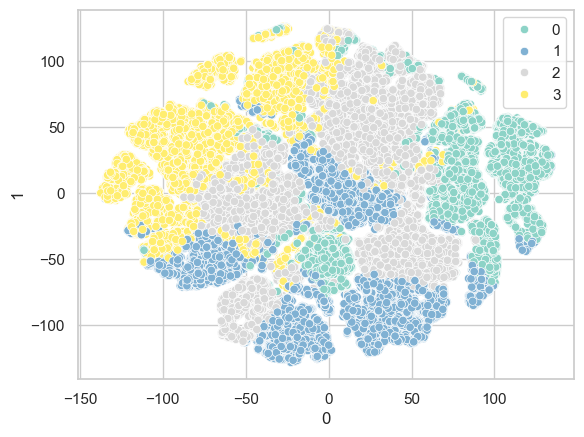

In [ ]:
pallete = sns.color_palette("Set3", as_cmap=True) 
sns.scatterplot(x=data[0], y=data[1], hue=kproto.labels_, palette=pallete)

In [ ]:
# обратно преобразуем признаки, для интерпритации
df[num_columns] = scaler.inverse_transform(df[num_columns])
num_columns.extend(['education','gender','age'])
df['clasters'] = kproto.labels_+1

In [ ]:
df_pivot = pd.pivot_table(df, columns='clasters', values=['gender','age','education','cost'] )
df_pivot

clasters,1,2,3,4
age,21.173848,39.590831,43.756289,41.444220
cost,44184.693088,28475.002016,53129.106412,31098.563495
education,0.142952,0.879364,0.961151,0.933277
gender,0.750218,0.636933,0.682092,0.343391


In [ ]:
# Соединяем таблицы с кластором и товарами и id в единую таблицу.
df_id_clients = pd.merge(left=df_clients, right=df_group, on='id', how='inner')
df_clients_clasters = pd.merge(left=df_id_clients, right=df['clasters'], left_index=True, right_index=True,how='inner')
df_4 = pd.merge(left=df_full, right=df_clients_clasters[['id','clasters']], on='id',how='inner')
df_4.head()

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,clasters
0,0,велосипед горный женский,мультицвет,13599,0.0,1,7,0.0,36.0,1.0,1201.0,32.0,0.5072,4
1,0,стол,зелёный,1499,2.0,0,37,0.0,36.0,1.0,1201.0,32.0,0.5072,4
2,0,набор стол стула,бежевый,4799,2.0,0,37,0.0,36.0,1.0,1201.0,32.0,0.5072,4
3,3,бутсы мужские,белый,1599,1.0,0,13,1.0,31.0,1.0,1134.0,32.0,0.4304,2
4,3,мяч футбольный,мультицвет,7199,2.0,0,27,1.0,31.0,1.0,1134.0,32.0,0.4304,2


In [ ]:
df_1c = df_4[df_4['clasters'] == 1]
df_1c.head()

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,clasters
120,27,кроссовки мужские,светло-серый,3499,1.0,0,4,1.0,17.0,0.0,1137.0,32.0,0.2672,1
121,27,мяч баскетбольный,мультицвет,1399,2.0,0,47,1.0,17.0,0.0,1137.0,32.0,0.2672,1
137,39,полуботинки мужские,мультицвет,19599,1.0,0,30,1.0,21.0,0.0,1188.0,32.0,0.4688,1
138,39,футболка мужская,морской,599,1.0,0,43,1.0,21.0,0.0,1188.0,32.0,0.4688,1
139,39,лонгслив мужской,чёрный,499,1.0,1,43,1.0,21.0,0.0,1188.0,32.0,0.4688,1


In [ ]:
print (f" Всего клиентов {len(df_1c['id'].unique())}, доля клиентов в группе {round(len(df_1c['id'].unique())/(len(df_4['id'].unique())) * 100,2)} %")
print (f" Доля товаров, купленных клиентами из 1 кластера {round(len(df_1c)/ len(df_4) * 100,2)} %")
print (f" Сумма товаров, купленных клиентами из 1 кластера {(df_1c['cost'].sum())}")
print (f" Доля выручки от клиентов 1 кластера от общей суммы продаж {round(df_1c['cost'].sum()/df_4['cost'].sum()*100,2)} %")
print (f" Средняя стоимость товара {round(df_1c['cost'].mean(),2)}")
print (f" Доля товаров, купленных со скидкой в группе {round(len(df_1c [df_1c['base_sale'] == 1])/ len(df_1c['base_sale']) * 100,2)} %")

# Самые популярные товары в 1 кластере:
df_1c['product'].value_counts().head(20)

 Всего клиентов 19517, доля клиентов в группе 18.69 %
 Доля товаров, купленных клиентами из 1 кластера 18.77 %
 Сумма товаров, купленных клиентами из 1 кластера 862352655
 Доля выручки от клиентов 1 кластера от общей суммы продаж 20.42 %
 Средняя стоимость товара 5889.74
 Доля товаров, купленных со скидкой в группе 34.92 %


product
кроссовки мужские      14100
кеды мужские            6818
кроссовки женские       5330
футболка мужская        5037
брюки мужские           4972
шорты мужские           4371
полуботинки мужские     2735
кеды женские            2505
рюкзак                  2373
брюки женские           2126
футболка женская        2024
велосипед горный        1957
бейсболка               1923
ветровка мужская        1590
носки пары              1524
толстовка мужская       1383
сандалии женские        1363
палатка местная         1338
шорты женские           1281
худи мужская            1241
Name: count, dtype: int64

In [ ]:
df_2c = df_4[df_4['clasters'] == 2]
df_2c.head()

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,clasters
3,3,бутсы мужские,белый,1599,1.0,0,13,1.0,31.0,1.0,1134.0,32.0,0.4304,2
4,3,мяч футбольный,мультицвет,7199,2.0,0,27,1.0,31.0,1.0,1134.0,32.0,0.4304,2
5,3,кеды мужские,белый,2799,1.0,1,34,1.0,31.0,1.0,1134.0,32.0,0.4304,2
6,3,полуботинки мужские,серый,2999,1.0,0,34,1.0,31.0,1.0,1134.0,32.0,0.4304,2
7,4,роликовые коньки детские,мультицвет,9199,2.0,0,0,0.0,35.0,1.0,1134.0,32.0,0.5072,2


In [ ]:
print (f" Всего клиентов {len(df_2c['id'].unique())}, доля клиентов в группе {round(len(df_2c['id'].unique())/(len(df_4['id'].unique())) * 100,2)} %")
print (f" Доля товаров, купленных клиентами из 2 кластера {round(len(df_2c)/ len(df_4) * 100,2)} %")
print(f" Сумма товаров, купленных клиентами из 2 кластера {(df_2c['cost'].sum())}")
print(f" Доля выручки клиентов  2 кластера от общей суммы продаж {round(df_2c['cost'].sum()/df_4['cost'].sum()*100,2)} %")
print(f" Средняя стоимость товара {round(df_2c['cost'].mean(),2)}")
print(f" Доля товаров, купленных со скидкой в группе {round(len(df_2c [df_2c['base_sale'] == 1])/ len(df_2c['base_sale']) * 100,2)} %")

# Самые популярные товары во 2 кластере:
df_2c['product'].value_counts().head(20)

 Всего клиентов 23318, доля клиентов в группе 22.33 %
 Доля товаров, купленных клиентами из 2 кластера 13.93 %
 Сумма товаров, купленных клиентами из 2 кластера 663980097
 Доля выручки клиентов  2 кластера от общей суммы продаж 15.73 %
 Средняя стоимость товара 6108.32
 Доля товаров, купленных со скидкой в группе 18.94 %


product
кроссовки мужские          9203
кроссовки женские          4218
брюки мужские              3447
полуботинки мужские        3177
футболка мужская           2769
кеды мужские               2489
шорты мужские              2484
рюкзак                     1808
велосипед горный           1643
сандалии женские           1616
брюки женские              1510
кеды женские               1462
палатка местная            1385
футболка женская           1343
бейсболка                  1301
ветровка мужская           1058
сандалии мужские           1006
полуботинки женские         965
кроссовки для мальчиков     933
солнцезащитные очки         775
Name: count, dtype: int64

In [ ]:
df_3c = df_4[df_4['clasters'] == 3]
df_3c.head()

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,clasters
52,11,сандалии женские,не определено,1599,0.0,0,4,0.0,39.0,1.0,1190.0,32.0,0.5072,3
53,11,кроссовки для девочек,серый,1399,2.0,0,26,0.0,39.0,1.0,1190.0,32.0,0.5072,3
54,11,рюкзак детский,не определено,799,2.0,0,26,0.0,39.0,1.0,1190.0,32.0,0.5072,3
55,11,футболка женская,не определено,599,0.0,0,27,0.0,39.0,1.0,1190.0,32.0,0.5072,3
56,11,сандалии женские,серый,4874,0.0,1,28,0.0,39.0,1.0,1190.0,32.0,0.5072,3


In [ ]:
print (f" Всего клиентов {len(df_3c['id'].unique())}, доля клиентов в группе {round(len(df_3c['id'].unique())/(len(df_4['id'].unique())) * 100,2)} %")
print (f" Доля товаров, купленных клиентами из 3 кластера {round(len(df_3c)/ len(df_4) * 100,2)} %")
print(f" Сумма товаров, купленных клиентами из 3 кластера {(df_3c['cost'].sum())}")
print(f" Доля выручки клиентов  3 кластера от общей суммы продаж {round(df_3c['cost'].sum()/df_4['cost'].sum()*100,2)} %")
print(f" Средняя стоимость товара {round(df_3c['cost'].mean(),2)}")
print(f" Доля товаров, купленных со скидкой в группе {round(len(df_3c [df_3c['base_sale'] == 1])/ len(df_3c['base_sale']) * 100,2)} %")

# Самые популярные товары в 3 кластере:
df_3c['product'].value_counts().head(20)

 Всего клиентов 35419, доля клиентов в группе 33.91 %
 Доля товаров, купленных клиентами из 3 кластера 39.9 %
 Сумма товаров, купленных клиентами из 3 кластера 1881779820
 Доля выручки клиентов  3 кластера от общей суммы продаж 44.57 %
 Средняя стоимость товара 6045.57
 Доля товаров, купленных со скидкой в группе 24.1 %


product
кроссовки мужские          26391
брюки мужские              11149
полуботинки мужские        10861
кроссовки женские           9741
футболка мужская            9520
шорты мужские               7307
кеды мужские                6696
рюкзак                      5460
бейсболка                   4218
брюки женские               3923
палатка местная             3806
ветровка мужская            3800
сандалии женские            3777
велосипед горный            3648
футболка женская            3634
сандалии мужские            3144
кеды женские                2848
полуботинки женские         2719
кроссовки для мальчиков     2519
толстовка мужская           2499
Name: count, dtype: int64

In [ ]:
df_4c = df_4[df_4['clasters'] == 4]
df_4c.head()

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,clasters
0,0,велосипед горный женский,мультицвет,13599,0.0,1,7,0.0,36.0,1.0,1201.0,32.0,0.5072,4
1,0,стол,зелёный,1499,2.0,0,37,0.0,36.0,1.0,1201.0,32.0,0.5072,4
2,0,набор стол стула,бежевый,4799,2.0,0,37,0.0,36.0,1.0,1201.0,32.0,0.5072,4
29,7,бутсы для мальчиков,мультицвет,4499,2.0,0,6,0.0,37.0,1.0,1198.0,32.0,0.5072,4
30,7,гетры,мультицвет,1199,2.0,0,13,0.0,37.0,1.0,1198.0,32.0,0.5072,4


In [ ]:
print (f" Всего клиентов {len(df_4c['id'].unique())}, доля клиентов в группе {round(len(df_4c['id'].unique())/(len(df_4['id'].unique())) * 100,2)} %")
print (f" Доля товаров, купленных клиентами из 4 кластера {round(len(df_4c)/ len(df_4) * 100,2)} %")
print(f" Cумма товаров, купленных клиентами из 4 кластера {(df_4c['cost'].sum())}")
print(f" Доля выручки клиентов 4 кластера от общей суммы продаж {round(df_4c['cost'].sum()/df_4['cost'].sum()*100,2)} %")
print(f" Средняя стоимость товара {round(df_4c['cost'].mean(),2)}")
print(f" Доля товаров, купленных со скидкой в группе {round(len(df_4c [df_4c['base_sale'] == 1])/ len(df_4c['base_sale']) * 100,2)} %")

# Самые популярные товары в 4 кластере:
df_4c['product'].value_counts().head(20)

 Всего клиентов 26183, доля клиентов в группе 25.07 %
 Доля товаров, купленных клиентами из 4 кластера 27.4 %
 Cумма товаров, купленных клиентами из 4 кластера 814253688
 Доля выручки клиентов 4 кластера от общей суммы продаж 19.28 %
 Средняя стоимость товара 3809.66
 Доля товаров, купленных со скидкой в группе 61.39 %


product
кроссовки женские          11269
кроссовки мужские          10894
брюки женские               7926
футболка женская            7565
брюки мужские               4839
полуботинки мужские         4534
футболка мужская            4350
кеды женские                4311
сандалии женские            4282
ветровка женская            3899
кеды мужские                3491
шорты женские               3414
полуботинки женские         3253
шорты мужские               3164
купальник женский           2922
легинсы женские             2775
рюкзак                      2746
кроссовки для мальчиков     2677
худи женская                2465
кроссовки для девочек       2384
Name: count, dtype: int64

#### Вывод:

Клиентская база разбивается на следующие 4 кластера:

1.	Самая многочисленная группа клиентов 35419 (33,91%), самый высокий средний возраст 43,75 года, 68% мужчины, со средним образованием (96%). Совершили покупок на 1,88 млрд. (44,57% от всех покупок за период) и совершили 39,9% покупок. На каждый клиент в среднем купил на 53129. Доля товаров, купленных со скидкой 24,1%

2.	Это группа клиентов принесла 663 млн. выручки (15,73%). Всего 23318 покупателей (22,33%). Ср. возраст 39,59 лет, 63% мужчины, со средним образованием (87%). Доля купленных товаров 13,93%. Каждый клиент в среднем купил на 28475. Доля товаров, купленных по скидке 18,94%.

3.	В этом кластере 26183 клиентов (25,07%). Эти клиенты приобрели товаров на 814 млн.(19,28%). Ср. возраст 41,44 года. 66% женщины со средним образованием. Каждый клиент в среднем приобрел на 31098,56.  В этой группе самое большое количество товаров, купленных по скидке 61,39%

4.	Самая молодая группа. 19517 клиентов (18,69%). Ср. возраст 21 год. 75% мужчины, с высшим образованием 85,7%. Это группа купила на 862 млн. (20,42%). Каждый клиент в среднем купил на 44184. Доля товаров купленных по скидке 34,92%.


### Модель склонности клиента к покупке товара

In [ ]:
# Извлекаем данные из 1 и 2 маркетинговых компаний
df_1company = df_4[(df_full['dt'] >= 5) & (df_4['dt'] < 17)]
df_1company = df_1company.loc[df_1company['id'].isin(positive_id), :]
df_1company 

C:\Users\svu20\AppData\Local\Temp\ipykernel_2400\1655595959.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_1company = df_4[(df_full['dt'] >= 5) & (df_4['dt'] < 17)]


,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,clasters
0,0,велосипед горный женский,мультицвет,13599,0.0,1,7,0.0,36.0,1.0,1201.0,32.0,0.5072,4
16,6,футболка мужская,темно-синий,999,1.0,0,8,1.0,52.0,1.0,1188.0,32.0,0.4304,2
17,6,бейсболка детская,синий,1119,2.0,1,11,1.0,52.0,1.0,1188.0,32.0,0.4304,2
18,6,носки детские пары,мультицвет,299,2.0,0,11,1.0,52.0,1.0,1188.0,32.0,0.4304,2
19,6,кроссовки мужские,чёрный,7399,1.0,0,11,1.0,52.0,1.0,1188.0,32.0,0.4304,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780027,177982,легкая куртка мужская,синий,4999,1.0,0,13,1.0,38.0,1.0,1134.0,32.0,0.4304,3
780028,177982,куртка мужская,чёрный,7999,1.0,0,13,1.0,38.0,1.0,1134.0,32.0,0.4304,3
780029,177982,брюки мужские,чёрный,12599,1.0,0,14,1.0,38.0,1.0,1134.0,32.0,0.4304,3
780030,177982,бейсболка,чёрный,1999,2.0,0,15,1.0,38.0,1.0,1134.0,32.0,0.4304,3


In [ ]:
df_2company = df_4[(df_4['dt'] == 15) | (df_4['dt'] == 45)]
df_2company = df_2company[df_2company['city'] == 1134 ]
df_2company.head()

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,clasters
421,98,,зелёный,28500,2.0,0,45,0.0,31.0,1.0,1134.0,32.0,0.5072,4
437,101,джемпер флисовый женский,небесный,4499,0.0,0,15,0.0,33.0,1.0,1134.0,32.0,0.5072,4
471,105,электросамокат,не определено,29999,2.0,0,15,1.0,33.0,1.0,1134.0,32.0,0.4304,3
548,130,ботинки утепленные женские,серый,5999,0.0,1,15,0.0,63.0,1.0,1134.0,32.0,0.5072,4
575,148,бейсболка детская,милитари,799,2.0,0,15,0.0,40.0,1.0,1134.0,32.0,0.5072,4


In [ ]:
# Объединияем данные из 1 и 2 компании , удаляем дубликаты и формируем тренировочную выборку
df_1_2_company = pd.concat([df_1company,df_2company])
df_1_2_company = df_1_2_company.drop_duplicates()
df_train= df_1_2_company.groupby('id', as_index=False).agg({'product': pd.Series.count, 'gender': 'min', 'age': 'min' , 'education':'min', 'personal_coef' : 'min','clasters': 'min'})
df_train['target'] = df_train['product'].apply(lambda x: 2 if x > 7 else (1 if 3 < x <= 7 else 0))
df_train.head()

,id,product,gender,age,education,personal_coef,clasters,target
0,0,1,0.0,36.0,1.0,0.5072,4,0
1,6,5,1.0,52.0,1.0,0.4304,2,1
2,9,2,0.0,48.0,1.0,0.5072,4,0
3,13,6,0.0,40.0,1.0,0.5072,4,1
4,18,6,1.0,53.0,1.0,0.4304,3,1


In [ ]:
df_train['target'].value_counts()

target
0    6569
1    2324
2    1185
Name: count, dtype: int64

In [ ]:
# Формируем тестовую выборку
df_test = df_clients[(df_clients.city == 1188) & (df_clients.country == 32)]
df_test = df_test.merge(df_4[['id','clasters']], how='inner', on='id')
df_test = df_test.drop_duplicates()
df_test.head()

,id,gender,age,education,city,country,personal_coef,clasters
0,6,1.0,52,1,1188,32,0.4304,2
15,18,1.0,53,1,1188,32,0.4304,3
32,39,1.0,21,0,1188,32,0.4688,1
39,40,1.0,35,0,1188,32,0.4688,3
44,88,0.0,37,1,1188,32,0.5072,3


In [ ]:
# Выравниваем кол-во строк в обоих выборках
x_train = df_train.drop(columns=['id','product','target']).iloc[:10000]
y_train = df_train['target'].iloc[:10000]
x_test = df_test.drop(columns=['id','city','country']).iloc[:10000]

In [ ]:
# Обучаем модель случайного леса
model = RandomForestClassifier() 
model.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
model_pred = model.predict(x_test)
x_test['product'] = model_pred


In [ ]:
x_test['product'].value_counts()

product
0    9649
1     260
2      91
Name: count, dtype: int64

In [ ]:
accuracy = accuracy_score(y_train, model_pred )
print(f"Точность модели: {accuracy:.2f}")

Точность модели: 0.64


 Точность модели случайного леса  - 64% \
 Из 10 000 жителей города 1188: \
 --   9649 человек купят менее 3 товаров \
 --   260 от 3 - 7 товаров \
 --   91 более 7 товаров  
